# Defensive Player of the Year Award Prediction Pipeline

## Setup and Data Loading

In [36]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss, classification_report
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load data
awards_data = pd.read_csv("../../initial_data/awards_players.csv")
teams_data = pd.read_csv("../../initial_data/teams.csv")
players_teams_clean = pd.read_csv("../awards_data/players_teams_clean.csv")
players_info = pd.read_csv("../../initial_data/players_clean.csv")

## Create Defensive Player of the Year Data

In [37]:
# Join dataset players_teams_clean data with teams_data
defpoty_data = players_teams_clean.merge(
    teams_data[['year', 'tmID', 'won', 'lost', 'rank', 'playoff', 'confID']], 
    left_on=['year', 'team'], 
    right_on=['year', 'tmID'], 
    how='left'
)

# Rename columns
defpoty_data.rename(columns={
    'won': 'team_wins', 
    'lost': 'team_losses', 
    'rank': 'conference_rank', 
    'playoff': 'playoff_made'
}, inplace=True)

defpoty_data.drop(columns=['tmID'], inplace=True)

# Process categorical columns
defpoty_data['playoff_made'] = defpoty_data['playoff_made'].map({'Y': 1, 'N': 0})
defpoty_data['confID'] = defpoty_data['confID'].astype('category').cat.codes

# Add player physical attributes
defpoty_data = defpoty_data.merge(
    players_info[['bioID', 'pos', 'height', 'weight']],
    left_on='playerID',
    right_on='bioID',
    how='left'
)
defpoty_data.drop(columns=['bioID'], inplace=True)

# Add DefPOTY winner field
target_award = 'Defensive Player of the Year'
defpoty_winners = awards_data[awards_data['award'] == target_award][['year', 'playerID']]

defpoty_data['DefPOTY_winner'] = defpoty_data.apply(
    lambda row: 1 if ((defpoty_winners['year'] == row['year']) & 
                      (defpoty_winners['playerID'] == row['playerID'])).any() else 0,
    axis=1
)

print(f"Data shape: {defpoty_data.shape}")
print(f"DefPOTY winners in dataset: {defpoty_data['DefPOTY_winner'].sum()}")

defpoty_data.to_csv("defpoty_data.csv", index=False)
print("✅ Saved to defpoty_data.csv")

Data shape: (1876, 27)
DefPOTY winners in dataset: 10
✅ Saved to defpoty_data.csv


## Define Features and Prepare Data

In [38]:
# Define feature columns
feature_columns = [
    'minutes','games_played','total_rebounds','rebounds_per_min','steals_per_min',
    'blocks_per_min','turnovers_per_min','team_wins','team_losses','conference_rank',
    'playoff_made','confID', 'pos', 'height', 'weight'
]

# Prepare dataset for training (Year N Stats -> Year N+1 Award)
data = pd.read_csv("defpoty_data.csv")

# Create award_year column (The year the award is given, based on prev year stats)
data['award_year'] = data['year'] + 1

# Get winners for the award year
winners = data[data['DefPOTY_winner'] == 1][['year', 'playerID']].copy()

# Merge to create target variable
data = data.merge(
    winners.rename(columns={'year': 'award_year'}),
    on=['award_year', 'playerID'],
    how='left',
    indicator=True
)
data['Target'] = (data['_merge'] == 'both').astype(int)
data.drop(columns=['_merge'], inplace=True)

# Filter candidates
candidates = data[
    (data['minutes'] >= 500) &
    (data['games_played'] >= 20)
].copy()

# Encode 'pos' column for models
candidates['pos'] = candidates['pos'].astype('category').cat.codes

print(f"Total candidates: {len(candidates)}")
print(f"Positive samples: {candidates['Target'].sum()}")

Total candidates: 866
Positive samples: 7


---
# Section 1: Single-Year Model Testing
Train on Award Years 2-9 (Stats 1-8), Test on Award Year 10 (Stats 9)

## 1.1 Logistic Regression

In [39]:
# Split data using award_year
train_award_years = [2, 3, 4, 5, 6, 7, 8, 9]
test_award_year = 10

train_data = candidates[candidates['award_year'].isin(train_award_years)].copy()
test_data = candidates[candidates['award_year'] == test_award_year].copy()

X_train = train_data[feature_columns]
y_train = train_data['Target']
X_test = test_data[feature_columns]
y_test = test_data['Target']

print(f"Train samples: {len(X_train)} | Test samples: {len(X_test)}")
print(f"Train positives: {y_train.sum()} | Test positives: {y_test.sum()}")

Train samples: 690 | Test samples: 89
Train positives: 6 | Test positives: 1


In [40]:
# Train Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
test_probs = model.predict_proba(X_test_scaled)[:, 1]

print("\n✅ Logistic Regression Model trained!")
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred):.3f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))


✅ Logistic Regression Model trained!
Train accuracy: 0.935
Test accuracy: 0.888

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.90      0.94        88
           1       0.00      0.00      0.00         1

    accuracy                           0.89        89
   macro avg       0.49      0.45      0.47        89
weighted avg       0.98      0.89      0.93        89



### Feature Importance (Logistic Regression)


Top 10 Most Important Features:
          feature  coefficient
turnovers_per_min    -2.229930
           weight    -2.046236
   blocks_per_min     1.996475
   steals_per_min     1.934698
 rebounds_per_min     1.539651
        team_wins     1.398738
  conference_rank     1.182171
          minutes     1.046520
   total_rebounds     0.762611
     games_played    -0.749349


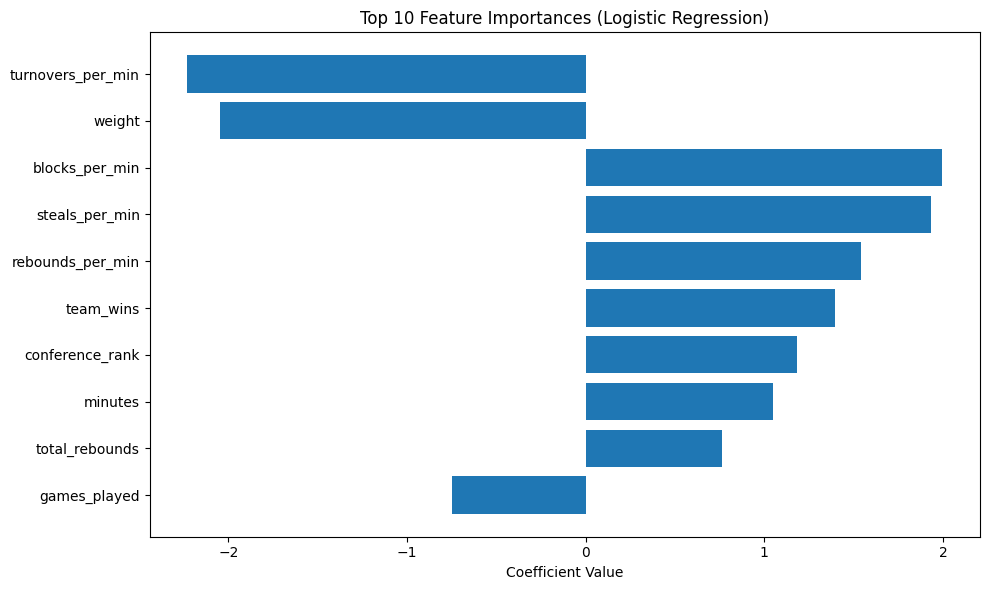

In [41]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(top_features['feature'], top_features['coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Importances (Logistic Regression)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Top Predictions (Logistic Regression)

In [42]:
# Show top predictions
test_data['lr_prob'] = test_probs
test_data_sorted = test_data.sort_values('lr_prob', ascending=False)

print(f"\nYear {test_year + 1} DefPOTY Predictions (Logistic Regression):")
print(f"{'Rank':<6}{'Player':<20}{'Team':<6}{'Probability':<12}{'Actual'}")
print("-" * 55)
for idx, (_, row) in enumerate(test_data_sorted.head(10).iterrows(), 1):
    actual = "✅ WINNER" if row['Target'] == 1 else ""
    print(f"{idx:<6}{row['playerID']:<20}{row['team']:<6}{row['lr_prob']:.4f}{'':6}{actual}")

NameError: name 'test_year' is not defined

## 1.2 XGBoost

In [ ]:
# Train XGBoost
scale_pos_weight = len(y_train[y_train == 0]) / max(len(y_train[y_train == 1]), 1)

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    verbosity=0
)
xgb_model.fit(X_train, y_train)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)
test_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("\n✅ XGBoost Model trained!")
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred_xgb):.3f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred_xgb):.3f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred_xgb))


✅ XGBoost Model trained!
Train accuracy: 1.000
Test accuracy: 0.989

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        88
           1       0.00      0.00      0.00         1

    accuracy                           0.99        89
   macro avg       0.49      0.50      0.50        89
weighted avg       0.98      0.99      0.98        89



### Feature Importance (XGBoost)


Top 10 Most Important Features (XGBoost):
          feature  importance
   steals_per_min    0.303261
           weight    0.181061
   total_rebounds    0.157073
   blocks_per_min    0.089544
           height    0.085078
 rebounds_per_min    0.081223
     games_played    0.035015
turnovers_per_min    0.024130
        team_wins    0.021867
          minutes    0.014127


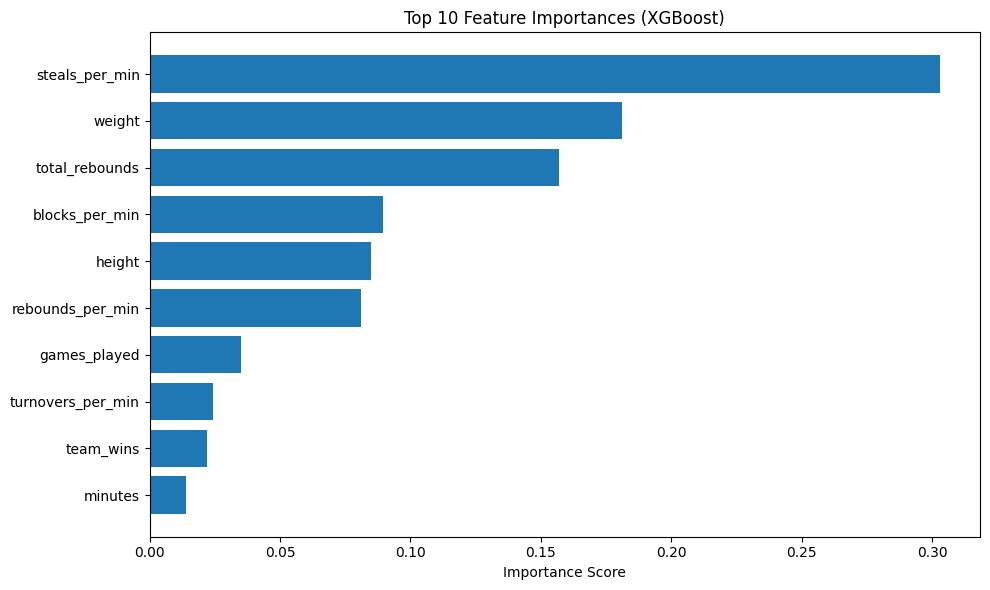

In [ ]:
# Get feature importance
feature_importance_xgb = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (XGBoost):")
print(feature_importance_xgb.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
top_features_xgb = feature_importance_xgb.head(10)
plt.barh(top_features_xgb['feature'], top_features_xgb['importance'])
plt.xlabel('Importance Score')
plt.title('Top 10 Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Top Predictions (XGBoost)

In [ ]:
# Show top predictions
test_data['xgb_prob'] = test_probs_xgb
test_data_sorted_xgb = test_data.sort_values('xgb_prob', ascending=False)

print(f"\nYear {test_year + 1} DefPOTY Predictions (XGBoost):")
print(f"{'Rank':<6}{'Player':<20}{'Team':<6}{'Probability':<12}{'Actual'}")
print("-" * 55)
for idx, (_, row) in enumerate(test_data_sorted_xgb.head(10).iterrows(), 1):
    actual = "✅ WINNER" if row['Target'] == 1 else ""
    print(f"{idx:<6}{row['playerID']:<20}{row['team']:<6}{row['xgb_prob']:.4f}{'':6}{actual}")


Year 10 DefPOTY Predictions (XGBoost):
Rank  Player              Team  Probability Actual
-------------------------------------------------------
1     hornbal01w          DET   0.1230      
2     penicti01w          SAC   0.0280      
3     snowmi01w           HOU   0.0233      
4     smithka01w          DET   0.0175      
5     brunsre01w          SAC   0.0146      
6     nolande01w          DET   0.0122      
7     fordch01w           DET   0.0119      
8     anosini01w          MIN   0.0119      
9     griffyo01w          SEA   0.0100      
10    rileyru01w          SAS   0.0090      


---
# Section 2: Multi-Year Evaluation (Leave-One-Out Cross-Validation)
Evaluate models across all available years

In [ ]:
# Leave-One-Out Cross-Validation Loop
# For each award year T, we train on all other award years

award_years = sorted(candidates['award_year'].unique())
results = []

print(f"Running Leave-One-Out Cross-Validation for Award Years {min(award_years)} to {max(award_years)}...")
print(f"{'Award Year':<12}{'LogReg Acc':<12}{'XGB Acc':<12}{'LogReg Rank':<12}{'XGB Rank':<12}{'Winner'}")
print("-" * 80)

for test_award_year in award_years:
    
    # Define Train and Test sets
    train_data_cv = candidates[candidates['award_year'] != test_award_year].copy()
    test_data_cv = candidates[candidates['award_year'] == test_award_year].copy()
    
    if len(test_data_cv) == 0:
        continue
        
    X_train_cv = train_data_cv[feature_columns]
    y_train_cv = train_data_cv['Target']
    X_test_cv = test_data_cv[feature_columns]
    y_test_cv = test_data_cv['Target']
    
    # --- Logistic Regression ---
    scaler_cv = StandardScaler()
    X_train_scaled_cv = scaler_cv.fit_transform(X_train_cv)
    X_test_scaled_cv = scaler_cv.transform(X_test_cv)
    
    lr_model_cv = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    lr_model_cv.fit(X_train_scaled_cv, y_train_cv)
    
    lr_pred_cv = lr_model_cv.predict(X_test_scaled_cv)
    lr_prob_cv = lr_model_cv.predict_proba(X_test_scaled_cv)[:, 1]
    lr_acc = accuracy_score(y_test_cv, lr_pred_cv)
    
    # --- XGBoost ---
    scale_pos_weight_cv = len(y_train_cv[y_train_cv == 0]) / max(len(y_train_cv[y_train_cv == 1]), 1)
    
    xgb_model_cv = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight_cv,
        max_depth=6,
        learning_rate=0.1,
        n_estimators=100,
        random_state=42,
        verbosity=0
    )
    xgb_model_cv.fit(X_train_cv, y_train_cv)
    
    xgb_pred_cv = xgb_model_cv.predict(X_test_cv)
    xgb_prob_cv = xgb_model_cv.predict_proba(X_test_cv)[:, 1]
    xgb_acc = accuracy_score(y_test_cv, xgb_pred_cv)
    
    # --- Check Rank of Actual Winner ---
    test_data_cv['lr_prob'] = lr_prob_cv
    test_data_cv['xgb_prob'] = xgb_prob_cv
    
    actual_winner_row = test_data_cv[test_data_cv['Target'] == 1]
    winner_id = "Unknown"
    lr_rank = "-"
    xgb_rank = "-"
    
    if len(actual_winner_row) > 0:
        winner_id = actual_winner_row.iloc[0]['playerID']
        
        test_data_sorted_lr = test_data_cv.sort_values('lr_prob', ascending=False).reset_index(drop=True)
        lr_rank = test_data_sorted_lr[test_data_sorted_lr['playerID'] == winner_id].index[0] + 1
        
        test_data_sorted_xgb = test_data_cv.sort_values('xgb_prob', ascending=False).reset_index(drop=True)
        xgb_rank = test_data_sorted_xgb[test_data_sorted_xgb['playerID'] == winner_id].index[0] + 1

    print(f"{test_award_year:<12}{lr_acc:.3f}{'':6}{xgb_acc:.3f}{'':6}{lr_rank:<12}{xgb_rank:<12}{winner_id}")
    
    results.append({
        'Award_Year': test_award_year,
        'LR_Acc': lr_acc,
        'XGB_Acc': xgb_acc,
        'LR_Rank': lr_rank if lr_rank != "-" else np.nan,
        'XGB_Rank': xgb_rank if xgb_rank != "-" else np.nan
    })

Running Leave-One-Out Cross-Validation for Award Years 2 to 11...
Award Year  LogReg Acc  XGB Acc     LogReg Rank XGB Rank    Winner
--------------------------------------------------------------------------------
2           0.913      0.989      25          14          blackde01w
3           0.935      1.000      -           -           Unknown
4           0.901      0.989      10          5           swoopsh01w
5           0.955      0.966      1           3           leslili01w
6           0.933      0.987      5           18          catchta01w
7           0.975      1.000      2           1           catchta01w
8           0.967      0.989      58          35          jacksla01w
9           0.938      0.988      -           -           Unknown
10          0.910      0.989      11          51          catchta01w
11          0.897      0.977      -           -           Unknown


## Summary of Multi-Year Results

In [ ]:
results_df = pd.DataFrame(results)

print("\nAverage Performance:")
print(f"Logistic Regression Accuracy: {results_df['LR_Acc'].mean():.3f}")
print(f"XGBoost Accuracy:             {results_df['XGB_Acc'].mean():.3f}")
print(f"Logistic Regression Avg Rank: {results_df['LR_Rank'].mean():.1f}")
print(f"XGBoost Avg Rank:             {results_df['XGB_Rank'].mean():.1f}")

best_model = "Logistic Regression" if results_df['LR_Rank'].mean() < results_df['XGB_Rank'].mean() else "XGBoost"
print(f"\n🏆 Recommended Model: {best_model}")


Average Performance:
Logistic Regression Accuracy: 0.932
XGBoost Accuracy:             0.987
Logistic Regression Avg Rank: 16.0
XGBoost Avg Rank:             18.1

🏆 Recommended Model: Logistic Regression


---
# Section 3: Predict for New Year
Use this section to predict DefPOTY for a future year using past data

## 3.1 Train Final Models on All Available Data

In [ ]:
# Train on ALL available data (years 1-10)
all_train_data = candidates[candidates['year'].isin([1,2,3,4,5,6,7,8,9,10])].copy()
X_all = all_train_data[feature_columns]
y_all = all_train_data['Target']

# Train Logistic Regression
scaler_final = StandardScaler()
X_all_scaled = scaler_final.fit_transform(X_all)
model_final = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model_final.fit(X_all_scaled, y_all)

# Train XGBoost
scale_pos_weight_final = len(y_all[y_all == 0]) / max(len(y_all[y_all == 1]), 1)
xgb_model_final = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight_final,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    verbosity=0
)
xgb_model_final.fit(X_all, y_all)

print("✅ Final models trained on all available data (Years 1-10)")

✅ Final models trained on all available data (Years 1-10)


## 3.2 Load New Year Data and Predict

In [ ]:
# Predict DefPOTY for new year using previous year stats
# Example: year_10_players_teams_test.csv -> use year 9 stats -> predict year 10 DefPOTY

new_year_file = "../../yearly_data/year_10_players_teams_test.csv"
predict_year = 10
stats_year = predict_year - 1

print(f"Predicting Year {predict_year} DefPOTY using Year {stats_year} stats")

# Load new year player list
new_year_players = pd.read_csv(new_year_file)
print(f"Players in year {predict_year}: {len(new_year_players)}")

# Get year N-1 stats for these players
player_stats = defpoty_data[
    (defpoty_data['year'] == stats_year) &
    (defpoty_data['playerID'].isin(new_year_players['playerID']))
].copy()

# Filter to candidates
new_candidates = player_stats[
    (player_stats['minutes'] >= 500) &
    (player_stats['games_played'] >= 20)
].copy()

# Encode pos
new_candidates['pos'] = new_candidates['pos'].astype('category').cat.codes

print(f"DefPOTY candidates: {len(new_candidates)}")

Predicting Year 10 DefPOTY using Year 9 stats
Players in year 10: 165
DefPOTY candidates: 87


### Predictions with Logistic Regression

In [ ]:
# Predict with Logistic Regression
X_new = new_candidates[feature_columns]
X_new_scaled = scaler_final.transform(X_new)
new_candidates['lr_probability'] = model_final.predict_proba(X_new_scaled)[:, 1]
new_candidates_sorted_lr = new_candidates.sort_values('lr_probability', ascending=False)

print(f"\nYear {predict_year} DefPOTY Predictions (Logistic Regression):")
print(f"{'Rank':<6}{'Player':<25}{'Team':<6}{'Probability':<12}{'Reb':<8}{'Stl':<8}{'Blk'}")
print("-" * 80)
for idx, (_, row) in enumerate(new_candidates_sorted_lr.head(15).iterrows(), 1):
    print(f"{idx:<6}{row['playerID']:<25}{row['team']:<6}{row['lr_probability']:.4f}{'':6}{row['total_rebounds']:<8}{row['steals_per_min']:.3f}{'':5}{row['blocks_per_min']:.3f}")

print(f"\n🏆 Predicted DefPOTY (LR): {new_candidates_sorted_lr.iloc[0]['playerID']}")


Year 10 DefPOTY Predictions (Logistic Regression):
Rank  Player                   Team  Probability Reb     Stl     Blk
--------------------------------------------------------------------------------
1     anosini01w               MIN   0.9752      231     0.082     0.047
2     hornbal01w               DET   0.9726      138     0.106     0.013
3     beviltu01w               IND   0.9592      68      0.067     0.005
4     catchta01w               IND   0.9302      157     0.071     0.016
5     leslili01w               LAS   0.8882      293     0.046     0.092
6     smithta01w               PHO   0.8816      176     0.039     0.040
7     parkeca01w               LAS   0.8647      313     0.038     0.068
8     jacksla01w               SEA   0.6888      147     0.045     0.048
9     fordch01w                DET   0.5435      208     0.038     0.014
10    brunsre01w               SAC   0.4862      213     0.046     0.026
11    whaleli01w               CON   0.4493      174     0.050     0

### Predictions with XGBoost

In [ ]:
# Predict with XGBoost
new_candidates['xgb_probability'] = xgb_model_final.predict_proba(X_new)[:, 1]
new_candidates_sorted_xgb = new_candidates.sort_values('xgb_probability', ascending=False)

print(f"\nYear {predict_year} DefPOTY Predictions (XGBoost):")
print(f"{'Rank':<6}{'Player':<25}{'Team':<6}{'Probability':<12}{'Reb':<8}{'Stl':<8}{'Blk'}")
print("-" * 80)
for idx, (_, row) in enumerate(new_candidates_sorted_xgb.head(15).iterrows(), 1):
    print(f"{idx:<6}{row['playerID']:<25}{row['team']:<6}{row['xgb_probability']:.4f}{'':6}{row['total_rebounds']:<8}{row['steals_per_min']:.3f}{'':5}{row['blocks_per_min']:.3f}")

print(f"\n🏆 Predicted DefPOTY (XGBoost): {new_candidates_sorted_xgb.iloc[0]['playerID']}")


Year 10 DefPOTY Predictions (XGBoost):
Rank  Player                   Team  Probability Reb     Stl     Blk
--------------------------------------------------------------------------------
1     catchta01w               IND   0.9966      157     0.071     0.016
2     hornbal01w               DET   0.0263      138     0.106     0.013
3     smithta01w               PHO   0.0214      176     0.039     0.040
4     snowmi01w                HOU   0.0198      230     0.021     0.036
5     wiggica01w               MIN   0.0187      97      0.066     0.008
6     penicti01w               SAC   0.0164      99      0.078     0.005
7     anosini01w               MIN   0.0081      231     0.082     0.047
8     jacksla01w               SEA   0.0060      147     0.045     0.048
9     brunsre01w               SAC   0.0050      213     0.046     0.026
10    leslili01w               LAS   0.0045      293     0.046     0.092
11    braxtka01w               DET   0.0031      168     0.024     0.041
12    r